# Implementing Decision Tree Classifier


## Importing Libraries


In [132]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix


## Importing and preprocessing the data


In [133]:
df = pd.read_csv(r'./data/nursery.csv')
df.dropna(inplace=True)


In [134]:
df.count()


parents             12960
has_nurs            12960
form                12960
children            12960
housing             12960
finance             12960
social              12960
health              12960
final evaluation    12960
dtype: int64

There is no missing data in the dataset. So, we can directly move on to the next step.


In [135]:
y = df['final evaluation']
X = df.drop(labels=['final evaluation'], axis=1)


## Implementing the model


In [2]:
class DecisionTreeClassifier:
    """
    Decision Tree Classifier
    Attributes:
        _max_depth: int, default=None
            The maximum depth of the tree. If None, then nodes are expanded
            until all leaves are pure or until all leaves contain less than
            min_samples_split samples.

        _main_tree: dict, default=None
            The main tree of the model.

        _leaf_name: str, default='leaf'
            The name of the leaf.

        _number_of_nodes: int, default=None
            The number of nodes in the tree.

        _number_of_leafs: int, default=None
            The number of leafs in the tree.

        _label_encoder: LabelEncoder, default=None
            The label encoder of the model.

        _X_encoder: list of LabelEncoder, default=None
            The list of label encoders of the model.

        _train_errors_list: list of float, default=None
            The list of train errors of the model.

        _test_errors_list: list of float, default=None
            The list of test errors of the model.

        _validation_errors_list: list of float, default=None
            The list of validation errors of the model.

        _list_of_nodes: list of dict, default=None
            The list of nodes in the tree.

        _impurity_name: str, default='entropy'
            The name of the impurity function.

    Methods:
        encode_X: Encode the X data.

        encode_y: Encode the y data.

        decode_y: Decode the y data.

        _get_probablity: Get the probablity of the data.

        _get_entropy: Get the entropy of the data.

        _get_gini: Get the gini of the data.

        _get_impurity: Get the impurity of the data.

        _get_information_gain: Get the information gain of the data.

        _get_best_split: Get the best split of the data.

        _get_best_feature: Get the best feature of the data.

        _get_best_threshold: Get the best threshold of the data.

        _get_best_split_for_feature: Get the best split for the feature.

        _get_best_split_for_threshold: Get the best split for the threshold.

        _get_best_split_for_feature_and_threshold: Get the best split for the
            feature and threshold.

        _get_best_split_for_feature_and_thresholds: Get the best split for the
            feature and thresholds.

        _get_best_split_for_feature_and_thresholds_for_node: Get the best split
            for the feature and thresholds for the node.

        _get_best_split_for_node: Get the best split for the node.


    """

    def __init__(self, max_depth=None, impurity='entropy'):
        """
        Initialize the DecisionTreeClassifier class.

        Parameters:
            max_depth: int, default=None
                The maximum depth of the tree. If None, then nodes are expanded
                until all leaves are pure or until all leaves contain less than
                min_samples_split samples.

            impurity: str, default='entropy'
                The name of the impurity function.

        Returns:
            None
        """
        self._max_depth = max_depth
        self._main_tree = None
        self._leaf_name = 'leaf'
        self._number_of_nodes = None
        self._number_of_leafs = None
        self._label_encoder = None
        self._X_encoder = None
        self._train_errors_list = None
        self._test_errors_list = None
        self._validation_errors_list = None
        self._list_of_nodes = None
        self._impurity_name = impurity

        if max_depth is not None and self._max_depth <= 0:
            raise Exception('_max_depth should be positive')

        if impurity == 'entropy':
            self.impurity = self._get_entropy

        elif impurity == 'gini':
            self.impurity = self._get_gini

        @property
        def max_depth(self):
            """Get the max_depth of the model."""
            return self._max_depth

        @property
        def main_tree(self):
            """Get the main_tree of the model."""
            return self._main_tree

        @property
        def leaf_name(self):
            """Get the leaf_name of the model."""
            return self._leaf_name

        @property
        def number_of_nodes(self):
            """Get the number_of_nodes of the model."""
            return self._number_of_nodes

        @property
        def number_of_leafs(self):
            """Get the number_of_leafs of the model."""
            return self._number_of_leafs

        @property
        def label_encoder(self):
            """Get the label_encoder of the model."""
            return self._label_encoder

        @property
        def X_encoder(self):
            """Get the X_encoder of the model."""
            return self._X_encoder

        @property
        def train_errors_list(self):
            """Get the train_errors_list of the model."""
            return self._train_errors_list

        @property
        def test_errors_list(self):
            """Get the test_errors_list of the model."""
            return self._test_errors_list

        @property
        def validation_errors_list(self):
            """Get the validation_errors_list of the model."""
            return self._validation_errors_list

        @property
        def list_of_nodes(self):
            """Get the list_of_nodes of the model."""
            return self._list_of_nodes

        @property
        def impurity_name(self):
            """Get the impurity_name of the model."""
            return self._impurity_name

    def encode_X(self, X):
        """
        Encode the X data.

        Parameters:
            X: numpy.ndarray
                The X data to encode.

        Returns:
            numpy.ndarray
                The encoded X data.
        """
        X = np.array(X)
        if self._X_encoder is None:
            self._X_encoder = [LabelEncoder().fit(X[:, i])
                               for i in range(X.shape[1])]

        return np.concatenate([
            self._X_encoder[i].transform(X[:, i]).reshape(-1, 1)
            for i in range(X.shape[1])], axis=1)

    def encode_y(self, y):
        """
        Encode the y data.

        Parameters:
            y: numpy.ndarray
                The y data to encode.

        Returns:
            numpy.ndarray
                The encoded y data.
        """
        self._label_encoder = LabelEncoder()
        return self._label_encoder.fit_transform(y)

    def decode_y(self, y):
        """
        Decode the y data.

        Parameters:
            y: numpy.ndarray
                The y data to decode.

        Returns:
            numpy.ndarray
                The decoded y data.
        """

        if self._label_encoder is None:
            raise Exception('Label encoder is not initialized')

        return self._label_encoder.inverse_transform(y)

    def _get_probablity(self, X):
        """
        Calculate the probablity of the X series.

        Parameters:
            X: numpy.ndarray
                The X data to calculate the probablity.

        Returns:
            numpy.ndarray
                The probablity of the X series.
        """
        return np.bincount(X)/X.shape[0]

    def _get_entropy(self, X):
        """
        Calculate the entropy of the X series.

        Parameters:
            X: numpy.ndarray
                The X data to calculate the entropy impurity.

        Returns:
            float
                The entropy of the X series.
        """
        X = self._get_probablity(X)
        X = X[X != 0]
        return np.dot(X, -np.log2(X))

    def _get_gini(self, X):
        """
        Calculate the gini of the X series.

        Parameters:
            X: numpy.ndarray
                The X data to calculate the gini impurity.

        Returns:
            float
                The gini of the X series.
        """
        X = self._get_probablity(X)
        return 1 - np.dot(X, X)

    def check_is_fitted(self):
        """ Check if the model is fitted. """
        if self._main_tree is None:
            raise Exception('model is not trained')

    def check_is_fit_prune_evaluate(self):
        """ Check if the model is fitted. """
        if self._train_errors_list is None:
            raise Exception('fit_prune_evaluate is not called')

    def get_information_gain(self, X, y):
        """
        Calculate the information gain of the columns.

        Parameters:
            X: numpy.ndarray
                The X data to calculate the information gain.

        Returns:
            numpy.ndarray
                The information gain of the columns.

        """

        if len(X.shape) != 2:
            raise Exception('X should be 2D array')

        info_gain = list()
        for i in range(X.shape[1]):
            X_selected = X[:, i]

            info_gain.append(self.impurity(y)
                             - np.sum(
                                 [self._get_probablity(X_selected)[j] *
                                  self.impurity(y[X_selected == j])
                                  for j in np.unique(X_selected)]))

        return np.array(info_gain)

    def _name_branch(self, depth, branch_number):
        """
        Name the branch.

        Parameters:
            depth: int
                The depth of the branch.

        Returns:
            str
                The name of the branch.
        """
        return branch_number

    def _split_nodes(self, X, y):
        """
        Split a node into sub nodes.

        Parameters:
            X: numpy.ndarray
                The X data to split the node.

            y: numpy.ndarray
                The y data to split the node.

        Returns:
            dict
                The sub nodes of the node.
        """

        if len(X.shape) != 2:
            raise Exception('X should be 2D array')

        if len(self.count_categories(X)) == 0:
            raise Exception('model is not trained')

        self._number_of_nodes += 1
        X_feature_arg = np.argmax(self.get_information_gain(X[1:, :], y))
        feature_arg = X[0, X_feature_arg]
        leftover_features = np.delete(X[0, :], X_feature_arg).reshape(1, -1)
        X = X[1:, :]
        X_selected = X[:, X_feature_arg]
        X = np.delete(X, X_feature_arg, axis=1)

        sub_nodes = dict()

        for i in self.columns_categories[feature_arg]:

            splitted_data = np.concatenate((leftover_features,
                                            X[X_selected == i]), axis=0)

            splitted_labels = y[X_selected == i]

            branch_name = self._name_branch(self._depth_iter, i)

            if len(splitted_labels) == 0:
                sub_nodes[branch_name] = {
                    self._leaf_name: [np.bincount(y).argmax(), [len(y)]]}
                self._number_of_leafs += 1
                continue

            if np.all(splitted_labels == splitted_labels[0]):
                sub_nodes[branch_name] = {self._leaf_name: [
                    splitted_labels[0], [len(splitted_labels)]]}
                self._number_of_leafs += 1
                continue

            sub_nodes[branch_name] = (splitted_data, splitted_labels)

        return {(feature_arg, tuple(np.bincount(y))): sub_nodes}

    def count_categories(self, columns):
        """
        Count the categories of the columns.

        Parameters:
            columns: numpy.ndarray
                The columns to count the categories.

        Returns:
            list
                The categories of the columns.
        """
        if len(columns.shape) != 2:
            raise Exception('X should be 2D array')

        return [np.unique(columns[:, i]) for i in range(columns.shape[1])]

    def summary(self):
        """ Print the summary of the model. """
        self.check_is_fitted()
        print('Impurity: {}'.format(self._impurity_name))
        print('Number of nodes: {}'.format(self._number_of_nodes))
        print('Number of leafs: {}'.format(self._number_of_leafs))
        print('Max depth: {}'.format(self._max_depth))

    def fit(self, X, y):
        """
        Fit the model.

        Parameters:
            X: numpy.ndarray
                The X data to fit the model.

            y: numpy.ndarray
                The y labels to fit the model.

        Returns:
            dict
                The main tree of the model.
        """

        if len(X.shape) != 2:
            raise Exception('X should be 2D array')

        if len(y.shape) != 1:
            raise Exception('y should be 1D array')

        if X.shape[0] != y.shape[0]:
            raise Exception('X and y should have same number of rows')

        if self._max_depth is None:
            self._max_depth = X.shape[1]

        self.columns_categories = self.count_categories(X)
        self._depth_iter = 0
        self._number_of_nodes = 0
        self._number_of_leafs = 0

        X = np.concatenate((np.arange(X.shape[1]).reshape(1, -1), X), axis=0)

        self._main_tree = self._split_nodes(X, y)
        sub_trees = [self._main_tree]

        for self._depth_iter in range(1, self._max_depth):
            sub_trees_temp = []
            for sub_tree in sub_trees:
                node = list(sub_tree.keys())[0]
                for branch in sub_tree[node]:

                    X_ys = sub_tree[node][branch]
                    if type(X_ys) == tuple:
                        sub_tree[node][branch] = self._split_nodes(
                            X_ys[0], X_ys[1])
                        sub_trees_temp.append(sub_tree[node][branch])

                sub_trees = sub_trees_temp

        # Replacing the not learned data with the maximum frequent one
        for sub_tree in sub_trees:
            node = list(sub_tree.keys())[0]
            for branch in sub_tree[node]:
                X_ys = sub_tree[node][branch]
                if type(X_ys) == tuple:
                    sub_tree[node][branch] = {self._leaf_name: [np.bincount(
                        X_ys[1]).argmax(), np.bincount(X_ys[1]).tolist()]}
                    self._number_of_leafs += 1
                    continue

        self._number_of_nodes += self._number_of_leafs

        return self._main_tree

    def _predict_on_tree(self, X, tree):
        """
        Predict the labels of the X data on special tree.

        Parameters:
            X: numpy.ndarray
                The X data to predict the labels.

            tree: dict
                The tree to predict the labels.

        Returns:
            numpy.ndarray
                The predicted labels.
        """

        self.check_is_fitted()
        if len(X.shape) != 2:
            raise Exception('X should be 2D array')

        y_predicted = list()
        for x in X:
            sub_tree = tree
            for depth in range(self.get_depth(tree)):
                node = list(sub_tree.keys())[0]
                if node == self._leaf_name:
                    break
                x_class = self._name_branch(depth, x[node[0]])
                sub_tree = sub_tree[node][x_class]

            y_predicted.append(sub_tree[self._leaf_name][0])

        return np.array(y_predicted)

    def _score_on_tree(self, X, y, tree):
        """
        Score the model on special tree.

        Parameters:
            X: numpy.ndarray
                The X data to score the model.

            y: numpy.ndarray
                The y labels to score the model.

            tree: dict
                The tree to score the model.

        Returns:
            float
                The score of the model.
        """

        return np.sum(self._predict_on_tree(X, tree) == y)/y.shape[0]

    def _error_on_tree(self, X, y, tree):
        """
        Error the model on special tree.

        Parameters:
            X: numpy.ndarray
                The X data to error the model.

            y: numpy.ndarray

            tree: dict
                The tree to error the model.

        Returns:
            float
                The error of the model.
        """
        return 1 - self._score_on_tree(X, y, tree)

    def predict(self, X):
        """
        Predict the labels of the X data.

        Parameters:
            X: numpy.ndarray
                The X data to predict the labels.
        Returns:
            numpy.ndarray
                The predicted labels.
        """
        return self._predict_on_tree(X, self._main_tree)

    def score(self, X, y):
        """
        Score the model.

        Parameters:
            X: numpy.ndarray
                The X data to score the model.

        Returns:
            float
                The score of the model.
        """
        return self._score_on_tree(X, y, self._main_tree)

    def error(self, X, y):
        """
        Error the model.

        Parameters:
            X: numpy.ndarray
                The X data to error the model.

        Returns:
            float
                The error of the model.
        """
        return self._error_on_tree(X, y, self._main_tree)

    def get_depth(self, tree):
        """
        Get the depth of the tree.

        Parameters:
            tree: dict
                The tree to get the depth.

        Returns:
            int
                The depth of the tree.
        """
        sub_trees = [tree]
        depth = 0
        while True:
            sub_trees_temp = []
            for sub_tree in sub_trees:
                node = list(sub_tree.keys())[0]

                for branch in sub_tree[node]:

                    sub_branch = sub_tree[node][branch]
                    if list(sub_branch.keys())[0] != self._leaf_name:
                        sub_trees_temp.append(sub_branch)

            depth += 1
            sub_trees = sub_trees_temp
            if len(sub_trees) == 0:
                return depth

    def _count_nodes(self, tree, depth):
        """
        Count the number of nodes in the tree.

        Parameters:
            tree: dict
                The tree to count the number of nodes.

            depth: int
                The depth of the tree.

        Returns:
            int
                The number of nodes in the tree.
        """
        if len(tree) != 1:
            raise Exception('tree should have one root node')

        _number_of_nodes = 1
        sub_trees = [tree]
        for _ in range(depth):
            sub_trees_temp = []
            for sub_tree in sub_trees:
                node = list(sub_tree.keys())[0]

                for branch in sub_tree[node]:
                    _number_of_nodes += 1
                    sub_branch = sub_tree[node][branch]
                    if list(sub_branch.keys())[0] != self._leaf_name:
                        sub_trees_temp.append(sub_branch)

            sub_trees = sub_trees_temp

        return _number_of_nodes

    def _count_leafs(self, tree, depth):
        """
        Count the number of leafs in the tree.

        Parameters:
            tree: dict
                The tree to count the number of leafs.

            depth: int
                The depth of the tree.

        Returns:
            int
                The number of leafs in the tree.
        """
        if len(tree) != 1:
            raise Exception('tree should have one root node')

        _number_of_leafs = 0
        sub_trees = [tree]
        for _ in range(depth):
            sub_trees_temp = []
            for sub_tree in sub_trees:
                node = list(sub_tree.keys())[0]

                for branch in sub_tree[node]:
                    sub_branch = sub_tree[node][branch]
                    if list(sub_branch.keys())[0] != self._leaf_name:
                        sub_trees_temp.append(sub_branch)
                    else:
                        _number_of_leafs += 1

            sub_trees = sub_trees_temp

        return _number_of_leafs

    def count_nodes(self, tree):
        """
        Count the number of nodes in the tree.

        Parameters:
            tree: dict
                The tree to count the number of nodes.

        Returns:
            int
                The number of nodes in the tree.
        """
        return self._count_nodes(tree, self.get_depth(tree))

    def count_leafs(self, tree):
        """
        Count the number of leafs in the tree.

        Parameters:
            tree: dict
                The tree to count the number of leafs.

        Returns:
            int
                The number of leafs in the tree.
        """
        return self._count_leafs(tree, self.get_depth(tree))

    def _get_subtrees(self, tree):
        """
        Get the subtrees of the tree.

        Parameters:
            tree: dict
                The tree to get the subtrees.

        Returns:
            list
                The subtrees of the tree.
        """

        if type(tree) != dict:
            raise Exception('tree should be dict')

        sub_trees = [[tree]]
        for depth in range(1, self.get_depth(tree)):
            sub_trees_on_depth = []
            for sub_tree in sub_trees[depth-1]:
                node = list(sub_tree.keys())[0]
                for branch in sub_tree[node]:
                    sub_branch = sub_tree[node][branch]
                    if list(sub_branch.keys())[0] != self._leaf_name:
                        sub_trees_on_depth.append(sub_branch)

            sub_trees.append(sub_trees_on_depth)

        return sub_trees

    def _fit_prune_evaluate(self, X_val, y_val,
                            X_train=None,
                            y_train=None,
                            X_test=None,
                            y_test=None,
                            max_prune_depth=1):
        """
        Fit the model, prune it and evaluate the model on the validation set
        and the test set.

        Parameters:
            X_val: numpy.ndarray
                The validation set.

            y_val: numpy.ndarray
                The labels of the validation set.

            X_train: numpy.ndarray
                The training set.

            y_train: numpy.ndarray
                The labels of the training set.

            X_test: numpy.ndarray
                The test set.

            y_test: numpy.ndarray
                The labels of the test set.

            max_prune_depth: int
                The maximum depth of the pruned tree.

        Returns:
            None
        """

        self.check_is_fitted()

        if len(X_val.shape) != 2:
            raise Exception('X should be 2D array')
        if len(y_val.shape) != 1:
            raise Exception('y should be 1D array')
        if X_val.shape[0] != y_val.shape[0]:
            raise Exception('X and y should have the same number of rows')
        if max_prune_depth >= self._max_depth:
            raise Exception('max_prune_depth should be less than _max_depth')

        if (X_train is not None):
            self.fit(X_train, y_train)
            self._train_errors_list = [self.score(X_train, y_train)]
            self._test_errors_list = [self.score(X_test, y_test)]
            self._validation_errors_list = [self.score(X_val, y_val)]
            self._list_of_nodes = [self._number_of_nodes]

        main_tree_pruned = deepcopy(self._main_tree)

        sub_trees = self._get_subtrees(main_tree_pruned)

        sampled_validation_set_number = int(np.log2(len(X_val)))

        for depth in range(self._max_depth-1,
                           self._max_depth-max_prune_depth-1,
                           -1):

            for sub_tree in sub_trees[depth]:
                node = list(sub_tree.keys())[0]
                node_samples = np.array(node[1])
                if node is self._leaf_name:
                    continue

                back_up_sub_tree = sub_tree[node]
                sub_tree.pop(node)

                sub_tree[self._leaf_name] = [np.argmax(node_samples),
                                             node_samples.tolist()]

                # Shuffling the validation set
                # X_val_sparse = coo_matrix(X_val)
                # X_val, X_sparse, y_val = shuffle(
                #     X_val, X_val_sparse, y_val, random_state=None)

                # Compare the validation error with the previous one
                # pruned_tree_error = self._error_on_tree(
                #     X_val[:sampled_validation_set_number],
                #     y_val[:sampled_validation_set_number],
                #     main_tree_pruned)

                # main_tree_error = self._error_on_tree(
                #     X_val[:sampled_validation_set_number],
                #     y_val[:sampled_validation_set_number],
                #     self._main_tree)

                pruned_tree_error = self._error_on_tree(
                    X_val, y_val, main_tree_pruned)

                main_tree_error = self._error_on_tree(
                    X_val, y_val, self._main_tree)

                if pruned_tree_error <= main_tree_error:
                    self._main_tree = deepcopy(main_tree_pruned)

                    self._max_depth = self.get_depth(self._main_tree)
                    self._number_of_leafs = self._count_leafs(
                        self._main_tree, self._max_depth)
                    self._number_of_nodes = self._count_nodes(
                        self._main_tree, self._max_depth)

                    if (X_train is not None):
                        self._train_errors_list.append(self.error(X_train,
                                                                  y_train))

                        self._test_errors_list.append(self.error(X_test,
                                                                 y_test))
                        self._validation_errors_list.append(self.error(X_val,
                                                                       y_val))
                        self._list_of_nodes.append(self._number_of_nodes)

                else:
                    sub_tree[node] = back_up_sub_tree

    def prune(self, X_val, y_val, max_prune_depth=1):
        """
        Prune the tree.

        Parameters:
            X_val: numpy.ndarray
                The validation set.

            y_val: numpy.ndarray
                The labels of the validation set.

            max_prune_depth: int
                The maximum depth of the pruned tree.

        Returns:
            None
        """
        return self._fit_prune_evaluate(X_val=X_val,
                                        y_val=y_val,
                                        max_prune_depth=max_prune_depth)

    def fit_prune_evaluate(self,
                           X_train,
                           y_train,
                           X_val,
                           y_val,
                           X_test,
                           y_test,
                           max_prune_depth=1):
        """
        Fit, prune and evaluate the tree.

        Parameters:
            X_train: numpy.ndarray
                The training set.

            y_train: numpy.ndarray
                The labels of the training set.

            X_val: numpy.ndarray
                The validation set.

            y_val: numpy.ndarray
                The labels of the validation set.

            X_test: numpy.ndarray
                The test set.

            y_test: numpy.ndarray
                The labels of the test set.

            max_prune_depth: int
                The maximum depth of the pruned tree.

        Returns:
            None
        """
        return self._fit_prune_evaluate(X_val=X_val,
                                        y_val=y_val,
                                        X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        max_prune_depth=max_prune_depth)

    def plot_error_curvs(self, figsize=(10, 10)):
        """
        Plot the error curves related to the training, test and validation
        sets.

        Parameters:
            figsize: tuple
                The size of the figure.

        Returns:
            None
        """
        self.check_is_fit_prune_evaluate()

        plt.figure(figsize=figsize)
        plt.plot(self._list_of_nodes,
                 self._train_errors_list, label='train error')
        plt.plot(self._list_of_nodes,
                 self._test_errors_list, label='test error')
        plt.plot(self._list_of_nodes,
                 self._validation_errors_list, label='validation error')
        plt.legend()
        plt.grid()
        plt.xlabel('Number of nodes')
        plt.ylabel('Error')
        plt.show()


## Encoding the data

In [137]:
model = DecisionTreeClassifier()
X_encoded = model.encode_X(X)
y_encoded = model.encode_y(y)

##


## Evaluate the the model with different size of training set and different hyperparameters

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.5, random_state=42)

model = DecisionTreeClassifier(max_depth=None, impurity='entropy')

model.fit(X_train, y_train)
print('training size 50%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


training size 50%
Train score: 1.0
Test score: 0.9651


In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=None, impurity='entropy')
model.fit(X_train, y_train)
model.summary()
print('training size 75%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: entropy
Number of nodes: 1075
Number of leafs: 767
Max depth: 8
training size 75%
Train score: 1.0
Test score: 0.9793


In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.5, random_state=42)

model = DecisionTreeClassifier(max_depth=6, impurity='entropy')
model.fit(X_train, y_train)
model.summary()
print('training size 50%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: entropy
Number of nodes: 571
Number of leafs: 405
Max depth: 6
training size 50%
Train score: 0.9784
Test score: 0.9551


In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=6, impurity='entropy')
model.fit(X_train, y_train)
model.summary()
print('training size 75%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: entropy
Number of nodes: 589
Number of leafs: 416
Max depth: 6
training size 75%
Train score: 0.9754
Test score: 0.966


#### Gini impurity

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.5, random_state=42)

model = DecisionTreeClassifier(max_depth=None, impurity='gini')
model.fit(X_train, y_train)
model.summary()
print('training size 50%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: gini
Number of nodes: 931
Number of leafs: 663
Max depth: 8
training size 50%
Train score: 1.0
Test score: 0.9681


In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=None, impurity='gini')
model.fit(X_train, y_train)
model.summary()
print('training size 75%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: gini
Number of nodes: 1062
Number of leafs: 756
Max depth: 8
training size 75%
Train score: 1.0
Test score: 0.9793


In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.5, random_state=42)

model = DecisionTreeClassifier(max_depth=6, impurity='gini')
model.fit(X_train, y_train)
model.summary()
print('training size 50%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: gini
Number of nodes: 578
Number of leafs: 410
Max depth: 6
training size 50%
Train score: 0.9798
Test score: 0.9565


In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=6, impurity='gini')
model.fit(X_train, y_train)
model.summary()
print('training size 75%')
print('Train score: {:.4}'.format(
    model.score(X_train, y_train)))
print('Test score: {:.4}'.format(model.score(X_test, y_test)))


Impurity: gini
Number of nodes: 580
Number of leafs: 408
Max depth: 6
training size 75%
Train score: 0.9756
Test score: 0.966


## Pruning the tree

In [150]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=2/9, random_state=42)

model = DecisionTreeClassifier(max_depth=None, impurity='gini')

model.fit(X_train, y_train)


{(7, (3050, 2989, 2, 2808, 223)): {0: {'leaf': [0, [3050]]},
  1: {(1,
    (0,
     1300,
     0,
     1685)): {0: {(0,
      (0,
       71,
       0,
       527)): {0: {(3,
        (0,
         1,
         0,
         205)): {0: {(2,
          (0,
           1,
           0,
           47)): {0: {(4,
            (0,
             1,
             0,
             12)): {0: {(5, (0, 1, 0, 3)): {0: {'leaf': [1, [1]]},
              1: {'leaf': [3, [3]]}}}, 1: {'leaf': [3, [5]]}, 2: {'leaf': [3,
              [4]]}}}, 1: {'leaf': [3, [10]]}, 2: {'leaf': [3,
            [12]]}, 3: {'leaf': [3, [13]]}}}, 1: {'leaf': [3,
          [55]]}, 2: {'leaf': [3, [48]]}, 3: {'leaf': [3, [55]]}}}, 1: {(2,
        (0,
         1,
         0,
         193)): {0: {(4,
          (0,
           1,
           0,
           46)): {0: {(3,
            (0,
             1,
             0,
             9)): {0: {(5, (0, 1, 0, 1)): {0: {'leaf': [1, [1]]},
              1: {'leaf': [3, [1]]}}}, 1: {'leaf': [3, [1]]}

In [151]:
model.summary()
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(model.score(X_test, y_test))


Impurity: gini
Number of nodes: 1083
Number of leafs: 776
Max depth: 8
1.0
0.9872685185185185
0.9807098765432098


In [152]:
model.fit_prune_evaluate(X_train, y_train, X_val, y_val,
                         X_test, y_test, max_prune_depth=2)
model.summary()
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(model.score(X_test, y_test))


Impurity: gini
Number of nodes: 949
Number of leafs: 678
Max depth: 7
0.9954805996472663
0.9872685185185185
0.9807098765432098


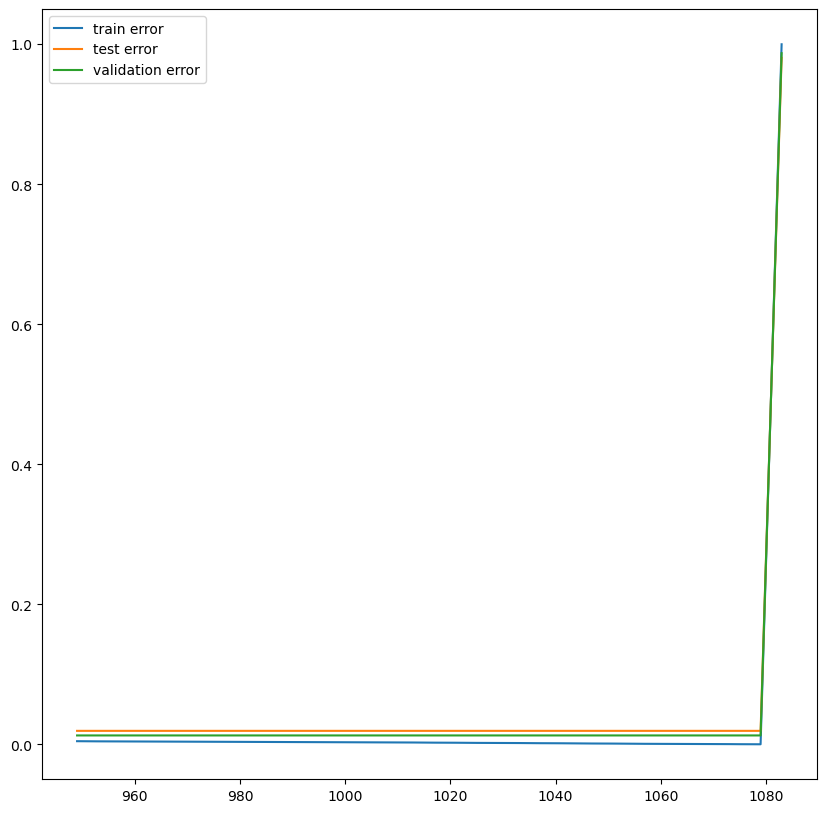

In [155]:
model.plot_error_curvs()